In [1]:
# imports
from OfflineSRL.MDPDataset.old_dataset import *
from OfflineSRL.MDP.old_MDP import MDP
from OfflineSRL.MDP.ChainBandit import ChainBanditMDP
from OfflineSRL.MDP.ChainBanditState import ChainBanditState
from OfflineSRL.BPolicy.ChainBanditPolicy import ChainBanditPolicy

# Learners
from OfflineSRL.OfflineLearners.offlineLearners import VI, PVI, SPVI, PesBandit

# GridWorld
from OfflineSRL.MDP.GridWorldMDPClass import GridWorldMDP
from OfflineSRL.MDP.GridWorldStateClass import GridWorldState
from OfflineSRL.BPolicy.UniformRandomPolicy import UniformRandomPolicy

# BluredTerminalGridWorld
from OfflineSRL.MDP.MABluredTerminalGridWorld import MultiArmBluredTerminalGridWorldMDP

import copy
import numpy as np
import math

In [2]:
def get_dataset(mdp, policy, horizon = 50, neps = 50):    
    # Generate data
    mdp.reset()
    observations = []
    actions = []
    rewards = []
    terminals = []
    for eps in range(neps):
        for timestep in range(horizon+2):
            # Get state.
            # Add state to list.
            cur_state = copy.deepcopy(mdp.cur_state)
            observations.append(copy.deepcopy(cur_state._vrepr()))

            # Get action
            # Add action to list
            cur_action = policy._get_action(state = cur_state)
            actions.append(copy.deepcopy(cur_action))

            # Execute action
            reward, next_state = mdp.execute_agent_action(cur_action)
            # Add reward
            rewards.append(copy.deepcopy(reward))

            terminals.append(0)
        mdp.reset()
        terminals[-1] = 1
        
    # Convert to MDPDataset format
    observations = np.array(observations)
    actions = np.array(actions)
    rewards = np.array(rewards)
    terminals = np.array(terminals)

    dataset = MDPDataset(
        observations=observations,
        actions=actions,
        rewards=rewards,
        terminals=terminals,
    )
    
    return observations, policy, dataset, actions, rewards, terminals

In [3]:
import math
def evaluate_learner(option, observations, mdp, policy, dataset, horizon, neps = 5000):
    max_step_reward = 1
    abs_max_ep_reward = 1
    min_step_reward = -1
    if option == "VI":
        vi = VI(name = "vi", states = observations, actions = policy.actions, epLen = horizon)
    if option == "PVI":
        vi = PVI(name = "pvi", states = observations, actions = policy.actions, epLen = horizon, 
                 max_step_reward = max_step_reward, min_step_reward = min_step_reward, abs_max_ep_reward = abs_max_ep_reward)
    if option == "SPVI":
        vi = SPVI(name = "spvi", states = observations, actions = policy.actions, epLen = horizon, bpolicy = policy,
                  max_step_reward = max_step_reward, min_step_reward = min_step_reward, abs_max_ep_reward = abs_max_ep_reward)
    if option == "PSL":
        vi = PesBandit(name = "psl", states = observations, actions = policy.actions, epLen = horizon)
    vi.fit(dataset)
    
    mdp.reset()
    viobservations = []
    viactions = []
    virewards = []
    viterminals = []
    for eps in range(neps):
        for timestep in range(horizon):
            # Get state.
            # Add state to list.
            cur_state = copy.deepcopy(mdp.cur_state)
            viobservations.append(copy.deepcopy(cur_state._vrepr()))

            # Get action
            # Add action to list
            cur_action = vi.act(copy.deepcopy(cur_state._vrepr()), timestep)
            viactions.append(copy.deepcopy(cur_action))

            # Execute action
            reward, next_state = mdp.execute_agent_action(cur_action)
            # Add reward
            virewards.append(copy.deepcopy(reward))

            viterminals.append(0)
        mdp.reset()
        viterminals[-1] = 1
    return np.sum(np.array(virewards))/neps

In [4]:
# Initialize MDP and Policy
#width, height = 10, 3
width, height = 5, 5
ma = 10
mdp = MultiArmBluredTerminalGridWorldMDP(width=width,
                 height=height,
                 ma = ma,
                 init_loc=(1, 1),
                 rand_init=True,
                 goal_locs=[(2,2)],
                 lava_locs=[()],
                 walls=[],
                 is_goal_terminal=True,
                 is_lava_terminal=False,
                 gamma=0.99,
                 slip_prob=0.0,
                 step_cost=0.0,
                 lava_cost=1.0,
                 name="bluredterminalgridworld")
policy = UniformRandomPolicy(mdp)
state_list = np.array([[i,j] for i in range(width+1) for j in range(height+1)])

In [5]:
rew_dict = {}
option_list = ["PSL","PVI","SPVI"]
for option in option_list:
    rew_dict[option] = {}
n_runs = 3
horizon = max(width, height)
neps_list = [50*int(math.pow(2,i)) for i in range(8)]
#neps_list = [int(math.pow(2,i))*20000 for i in range(5)] #+ [1000 + (i)*1000 for i in range(10)]
#neps_list = [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
#neps_list = [50, 100, 200, 400, 800, 1600]#, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
for neps in neps_list:
    print(neps)
    for option in option_list:
        rew_dict[option][neps] = []
    for run in range(n_runs):
        observations, policy, dataset, actions, rewards, terminals = get_dataset(mdp, policy, horizon = horizon, neps = neps)
        for option in option_list:
            rew_dict[option][neps].append(evaluate_learner(option, state_list, mdp, policy, dataset, horizon))
            #print(option)
            #print(option, neps, evaluate_learner(option, copy.deepcopy(observations), policy, dataset, horizon))

50
100
200
400
800
1600
3200
6400


In [6]:
rew = {}
err = {}
for option in option_list:
    rew[option] = []
    err[option] = []
for neps in neps_list:
    for option in option_list:
        rew[option].append(np.mean(rew_dict[option][neps]))
        err[option].append(np.std(rew_dict[option][neps])/np.sqrt(n_runs))

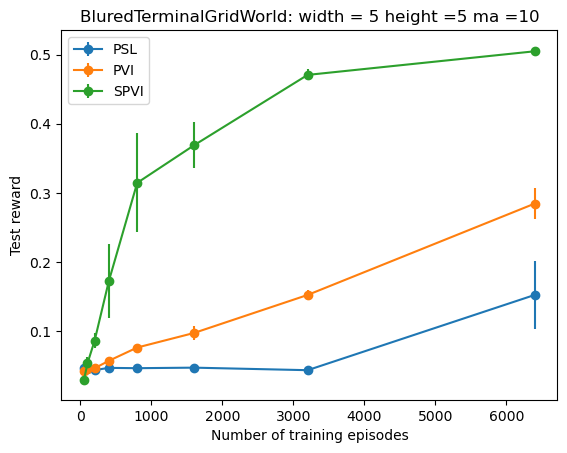

In [7]:
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

fig, ax = plt.subplots()
for option in option_list:
    x = neps_list
    y = rew[option]
    yerr = err[option]
    ax.errorbar(x, y,
                yerr=yerr,
                fmt='-o', label = option)


ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Test reward')
ax.set_title('BlurredTerminalGridWorld: width = '+str(width)+' height ='+str(height) +' ma ='+str(ma))
plt.legend()

plt.savefig('BlurredTerminalGridWorld: width = '+str(width)+' height ='+str(height)+' ma ='+str(ma))
plt.show()